This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program. If not, see <https://www.gnu.org/licenses/>. 

In [1]:
using DrWatson
@quickactivate "FastDysonSolver"

In [2]:
using Revise
includet("../src/Utils.jl")
select_BLAS()

Intel CPU detected


In [ ]:
using Revise
using BenchmarkTools

using LinearAlgebra
using HssMatrices
using NonEquilibriumGreenFunction
using StaticArrays

using CairoMakie
using Colors
using ColorSchemes
using LaTeXStrings

using SpecialFunctions
using Symbolics
using SymbolicNumericIntegration
using Interpolations
using DSP
using QuadGK


In [ ]:
function setup_figure()
    prl_width = 3.38583
    size = 170 .* (prl_width, 1 * prl_width)
    return Figure(size=size, fontsize=18)
end

In [ ]:
includet("./../src/Junction.jl")
local_default_compression() = HssCompression(atol=1e-6, rtol=1e-6, leafsize=128)

In [ ]:
function test()
    V = 1.2
    Γ = 5
    p = JunctionParameters(δt=0.2, T=400, ϕl=t -> 0, ϕr=t -> V * t, Δ=1, Γl=Γ, Γr=Γ, β=100)
    println("N = $( axis(p)|> length)")
    results = simulate_junction(p, cpr=HssCompression(kest=20, leafsize=64))
    compute_average_current(results)
end
test();

In [ ]:
function single_run(p,cpr)
    println("Computing Green functions")
    @time result = simulate_junction(p,cpr = cpr)
    println("Computing current")
    @time current = compute_average_current(result)
    return (result..., I = real.(current))
end
function measure_single_run(p,cpr)
    return @benchmark single_run($p,$cpr)
end

In [8]:
const ratioF64 = 1.0;
function getBeta()
    return 100
end
function base_VS_tf_δt()
    return 0.025/ratioF64
end
function benchmark_range_tf(::HssCompression)
    #return base_VS_tf_δt() .* [2^k for k = 7:11] .* ratioF64
    return base_VS_tf_δt() .* [2^k for k = 7:15] .* ratioF64
end
function benchmark_range_tf(::NONCompression)
    return base_VS_tf_δt() .* [2^k for k = 7:11] .* ratioF64
    #return base_VS_tf_δt() .* [2^k for k = 7:9] .* ratioF64
end
function applied_voltage(T)
    dphi_max = 16pi 
    return dphi_max/(2*T)
end
function phase_difference(T)
    @variables tau, t
    V = applied_voltage(T)
    expr = integrate(2V,(tau,0,t), detailed = false, symbolic = true)
    δϕ = build_function(expr, t, expression=Val{false})
    return δϕ
end
function time_VS_tf_parameters(T)
    δϕ = phase_difference(T)
    δt = base_VS_tf_δt() 
    return JunctionParameters(δt=δt, T=T, ϕl=t -> -δϕ(t)/2, ϕr=t -> δϕ(t)/2, Δ=1, Γl=5, Γr=5, β=getBeta())
end
function benchmark_time_VS_tf(cpr)
    return map(benchmark_range_tf(cpr)) do tf
        param = time_VS_tf_parameters(tf)
        @show N(param) 
        measure_single_run(param, cpr)
    end
end
function observe_time_VS_tf(cpr)
    return map(benchmark_range_tf(cpr)) do tf
        param = time_VS_tf_parameters(tf)
        @show N(param) 
        @time result = single_run(param, cpr)
        if cpr isa HssCompression
            return (hssrank_GR=hssrank(matrix(result[:G_R])), hssrank_GK=hssrank(matrix(result[:G_K])),
                param=param, I=result[:I])
        else
            return (I=result[:I], param=param)
        end
    end
end

observe_time_VS_tf (generic function with 1 method)

In [9]:
result_time_VS_tf_hss = observe_time_VS_tf(local_default_compression());
result_time_VS_tf_full = observe_time_VS_tf(NONCompression());

N(param) = 129
Computing Green functions
  0.177605 seconds (146.82 k allocations: 203.752 MiB, 14.86% gc time, 26.53% compilation time)
Computing current
  0.077735 seconds (34.65 k allocations: 124.014 MiB, 29.53% gc time)
  0.328097 seconds (193.93 k allocations: 328.388 MiB, 15.04% gc time, 36.39% compilation time)
N(param) = 257
Computing Green functions
  0.300702 seconds (109.54 k allocations: 471.609 MiB, 23.68% gc time, 2.18% compilation time)
Computing current
  0.148877 seconds (58.31 k allocations: 303.446 MiB, 15.38% gc time)
  0.450306 seconds (167.97 k allocations: 775.065 MiB, 20.90% gc time, 1.45% compilation time)
N(param) = 513
Computing Green functions
  0.714234 seconds (196.88 k allocations: 1.028 GiB, 40.31% gc time, 1.03% compilation time)
Computing current
  0.439342 seconds (105.53 k allocations: 715.561 MiB, 32.08% gc time)
  1.153945 seconds (302.53 k allocations: 1.727 GiB, 37.17% gc time, 0.64% compilation time)
N(param) = 1025
Computing Green functions
  

In [10]:
using ProgressMeter
includet("../src/AdaptativeSampler.jl")
function compute_equilibrium_Idc(base_parameters, n_samples; phi_max = 2pi)
    prog = Progress(n_samples, desc = "Adaptive Sampling")
    initial_number_of_points = 4 * Int(round(phi_max / 2pi))
    first_sample = LinRange(0, phi_max, initial_number_of_points)
    function sample(phi)
        r =  single_run_thermal_equilibrium_current(base_parameters, phi, local_default_compression(), Tmax = 1000)
        dc = r[:I][end]
        next!(prog)
        return dc
    end
    phi,I = adaptive_sampling(sample, (0, phi_max), n_samples, initial_points = first_sample)
    return phi,I
end

compute_equilibrium_Idc (generic function with 1 method)

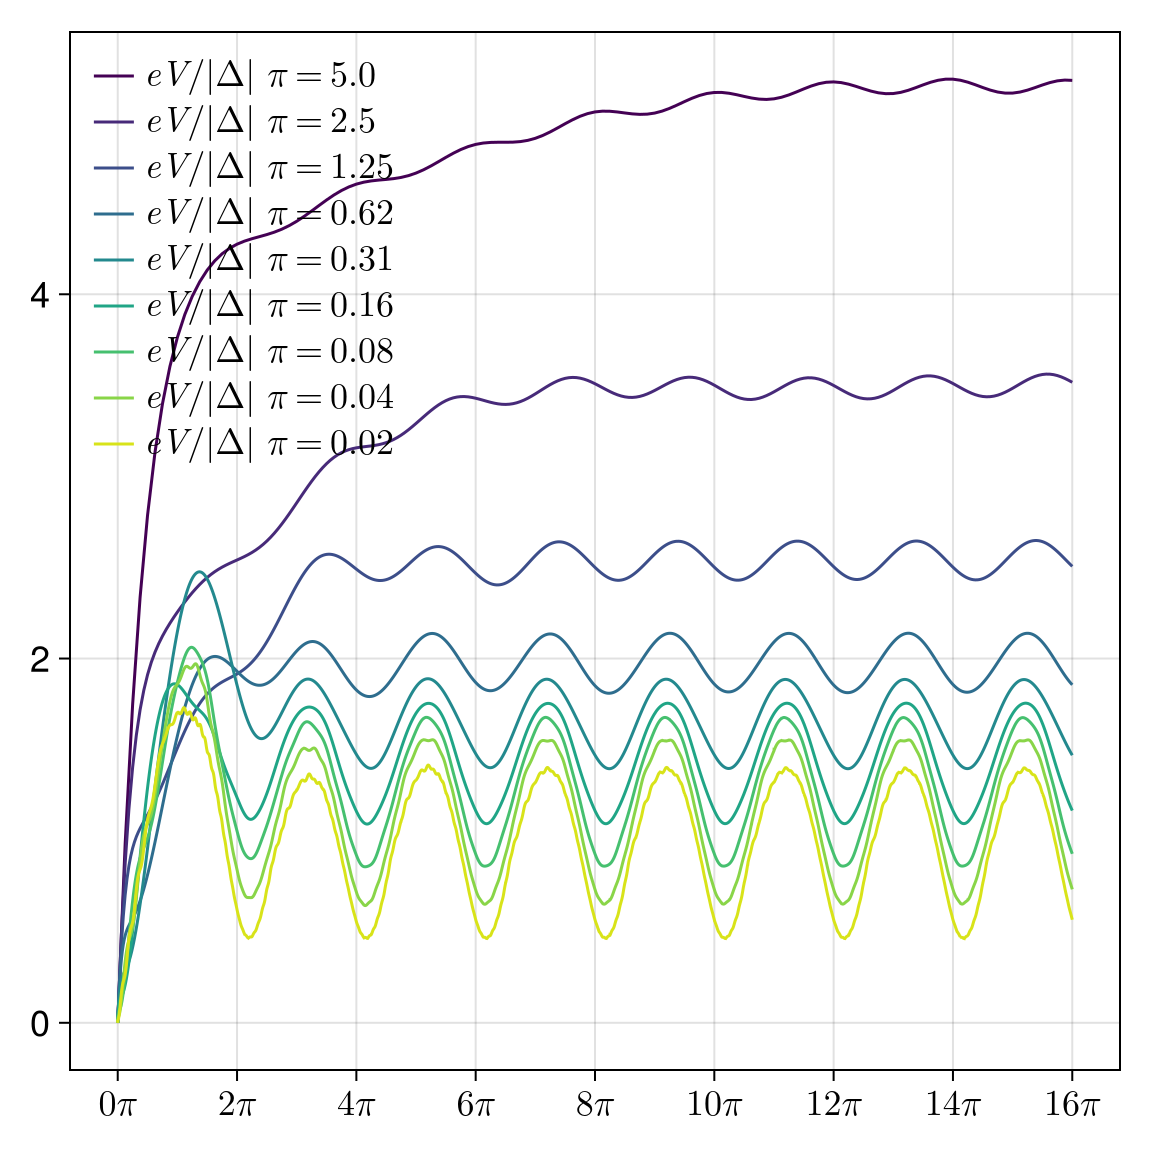

In [11]:
function get_colors(measures)
    return ColorSchemes.viridis[1:30:end] #reverse(colormap("Greens", length(measures) + 4)[4:end])
    #return cgrad(:Spectral, length(measures), categorical = true)
end

function get_theme(measures)
    colors = get_colors(measures)
    return Theme(
    #palette = (color = colors, ),
    #Lines = (cycle = Cycle([:color], covary = true),)
    )
end

function get_V(measures)
    tab_V = map(measures) do measure
        T = measure[:param].T
        V = 2 * applied_voltage(T)
    end
    return tab_V
end
function get_scaledV(measures)
    tab_V = get_V(measures)
    accuracy = 100
    return round.(tab_V / pi * accuracy) / accuracy
end

function get_scaledVmax(measures)
    return maximum(get_scaledV(measures))
end
function get_scaledVmin(measures)
    return minimum(get_scaledV(measures))
end


function plot_current(f_ax, measures)
    #ylims!(f_ax, 0, 6)
    colors = get_colors(measures)
    tab_V_label = get_scaledV(measures)
    for i in 1:length(measures)
        ax = measures[i][:param] |> axis
        n = ax |> length
        T = measures[i][:param].T
        δϕ = phase_difference(T)
        current = real.(measures[i][:I])
        V = 2 * applied_voltage(T)
        V_label = tab_V_label[i]
        lines!(f_ax, δϕ.(LinRange(0, T, n)), current, color=colors[i],
            label=L"eV/|\Delta| \ \pi = %$(V_label)")
    end
    f_ax
end

function plot_current(measures)
    f = setup_figure()
    T = measures[end][:param].T
    δϕ = phase_difference(T)
    δϕ_max = δϕ.(T)
    xticks = 0:2pi:δϕ_max
    xticks_for_label = (xticks / pi) .|> round .|> Int
    xticks_label = [L"%$t \pi" for t in xticks_for_label]
    fig_axis = Axis(f[1, 1], xticks=(xticks, xticks_label))
    plot_current(fig_axis, measures)
    axislegend(position=:lt, framevisible=false, fontsize=10)
    current_figure()
end
plot_current(result_time_VS_tf_hss)

In [12]:
measure_time_VS_tf_hss = benchmark_time_VS_tf(local_default_compression())
measure_time_VS_tf_full = benchmark_time_VS_tf(NONCompression())

N(param) = 129
Computing Green functions
  0.130438 seconds (59.78 k allocations: 199.638 MiB)
Computing current
  0.137428 seconds (34.64 k allocations: 123.828 MiB, 51.06% gc time)
Computing Green functions
  0.132868 seconds (59.77 k allocations: 199.414 MiB, 10.01% gc time)
Computing current
  0.075118 seconds (34.64 k allocations: 123.612 MiB, 17.18% gc time)
Computing Green functions
  0.152440 seconds (59.79 k allocations: 200.083 MiB, 29.91% gc time)
Computing current
  0.068246 seconds (34.62 k allocations: 123.942 MiB, 17.41% gc time)
Computing Green functions
  0.129980 seconds (59.79 k allocations: 199.701 MiB, 19.72% gc time)
Computing current
  0.082419 seconds (34.64 k allocations: 123.709 MiB, 20.25% gc time)
Computing Green functions
  0.129987 seconds (59.78 k allocations: 199.991 MiB, 18.66% gc time)
Computing current
  0.078790 seconds (34.62 k allocations: 123.844 MiB, 19.61% gc time)
Computing Green functions
  0.134611 seconds (59.78 k allocations: 199.871 MiB, 2

5-element Vector{BenchmarkTools.Trial}:
 32.146 ms
 151.764 ms
 838.889 ms
 6.367 s
 26.966 s

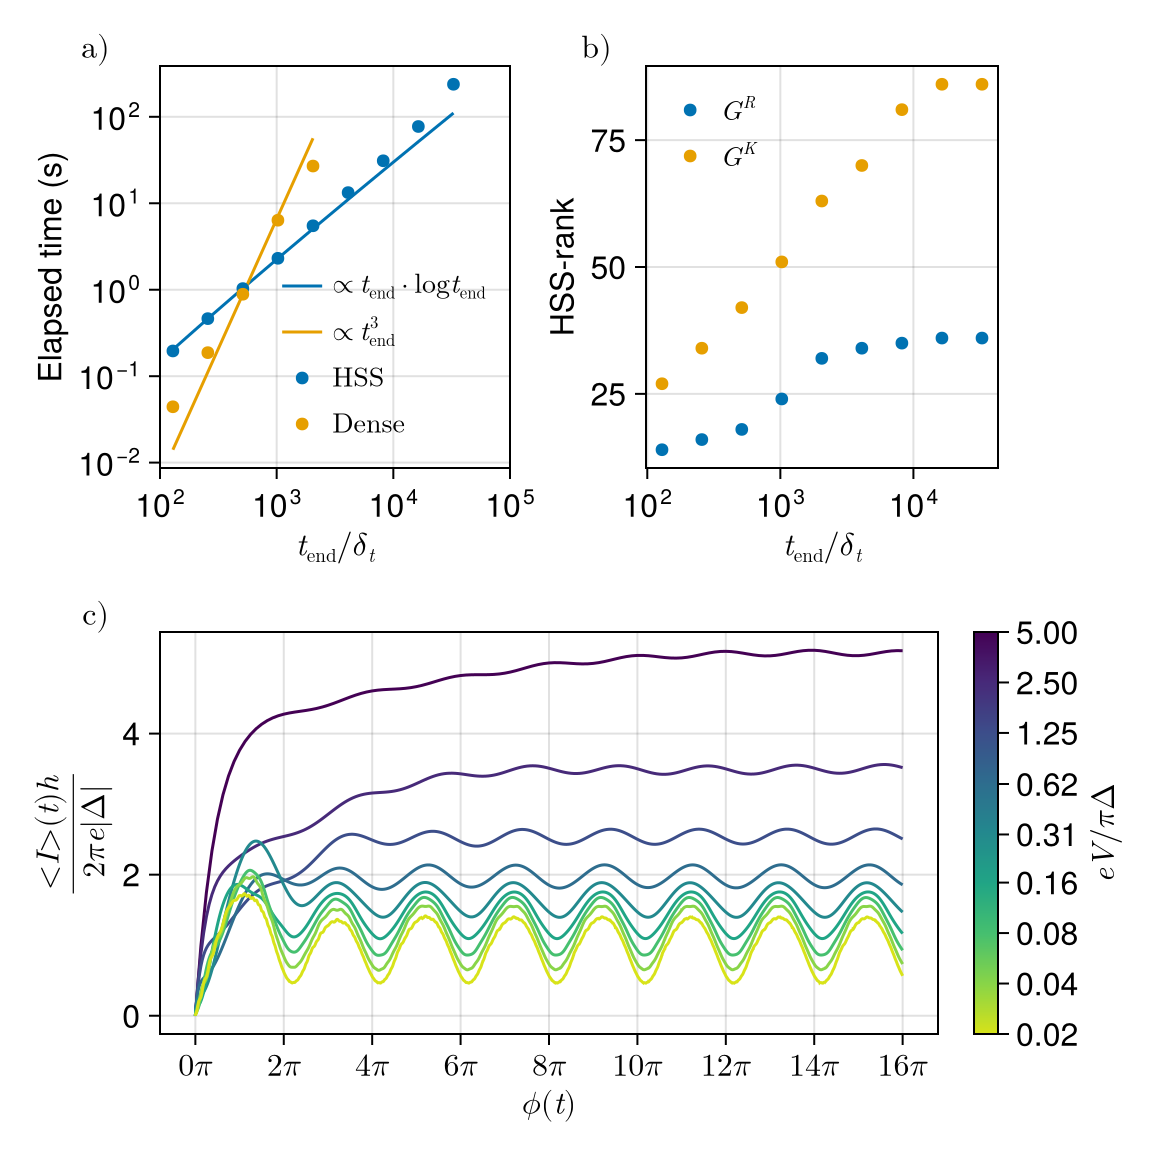

In [26]:
function plot_VS_tf(observation_hss, observation_full, measure_hss, measure_full)
    function mediantime_s(measure)
        return median(measure.times) * 1E-9
    end
    prl_width = 3.38583
    size = 170 .* (prl_width, 1 * prl_width)
    f = Figure(size=size, fontsize=16)
    f_ax = Axis(f[1, 1], xscale=log10, yscale=log10,
        xlabel=L"t_\text{end}/\delta_t",
        ylabel="Elapsed time (s)")
    xlims!(1E2,10^(5))
    asymptote_hss(x) = x * log(x)
    tendency_hss = asymptote_hss.(N_from_observation.(observation_hss)) ./ asymptote_hss(N_from_observation(observation_hss[2])) .* mediantime_s(measure_hss[2])
    lines!(f_ax, N_from_observation.(observation_hss),
        tendency_hss,
        label=L"\propto t_\text{end} \cdot \log t_\text{end}")
    asymptote_full(x) = x^3
    tendency_full = asymptote_full.(N_from_observation.(observation_full)) ./ asymptote_full(N_from_observation(observation_full[3])) .* mediantime_s(measure_full[3])
    lines!(f_ax, N_from_observation.(observation_full), tendency_full,
        label=L"\propto t_\text{end}^3")
    scatter!(f_ax,
        N_from_observation.(observation_hss),
        mediantime_s.(measure_hss),
        label=L"\text{HSS}")
    scatter!(f_ax,
        N_from_observation.(observation_full),
        mediantime_s.(measure_full),
        label=L"\text{Dense}")
    axislegend(position=:rb, framevisible=false, labelsize=14)
    Label(f[1,1,TopLeft()], L"\text{a)}")
    f_ax = Axis(f[1, 2], xscale=log10,
        xlabel=L"t_\text{end}/\delta_t",
        ylabel="HSS-rank"
    )
    scatter!(f_ax,
        [N(r[:param]) for r in observation_hss],
        [r[:hssrank_GR] for r in observation_hss],
        label=L"G^R")
    scatter!(f_ax,
        [N(r[:param]) for r in observation_hss],
        [r[:hssrank_GK] for r in observation_hss],
        label=L"G^K")
    axislegend(position=:lt, framevisible=false,labelsize=14)
    Label(f[1,2,TopLeft()], L"\text{b)}")
    T = observation_hss[end][:param].T
    δϕ = phase_difference(T)
    δϕ_max = δϕ.(T)
    xticks = 0:2pi:δϕ_max
    xticks_for_label = (xticks / pi) .|> round .|> Int
    xticks_label = [L"%$t \pi" for t in xticks_for_label]
    f_ax = Axis(
        f[2, 1:2][1, 1], xlabel=L"\phi(t)",
        ylabel=L"\frac{< I >(t)h}{2\pi e |\Delta|}",
        xticks=(xticks, xticks_label)
    )
    plot_current(f_ax, observation_hss)
    Colorbar(f[2, 1:2][1, 2],
        limits = (get_scaledVmin(observation_hss), get_scaledVmax(observation_hss)), 
        ticks=get_scaledV(observation_hss),
        colormap=reverse(get_colors(observation_hss)),
       # flipaxis=true,
        label=L"eV/\pi\Delta", 
        scale=log2
    )
    Label(f[2,1:2,TopLeft()], L"\text{c)}")
    #f[2, 4] = Legend(f, f_ax, "Voltage bias", framevisible = false, fontsize=10)
    return current_figure()
end
f = plot_VS_tf(result_time_VS_tf_hss, result_time_VS_tf_full, measure_time_VS_tf_hss, measure_time_VS_tf_full)
save("../plots/SQDS_benchmark_varying_t_end.pdf", f, pt_per_unit=1)
f

In [14]:
function dt_divider(::HssCompression)
    return 2 .^ (1:6)
end
function dt_divider(::NONCompression)
    return 2 .^ (1:4)
end
function get_T()
    benchmark_range_tf(local_default_compression())[1]
end
function time_VS_dt_parameters(T,divider)
    δϕ = phase_difference(T)
    δt = base_VS_tf_δt() ./ divider
    return JunctionParameters(δt=δt, T=T, ϕl=t -> -δϕ(t) / 2, ϕr=t -> δϕ(t) / 2, Δ=1, Γl=5, Γr=5, β=getBeta())
end
function benchmark_time_VS_dt(cpr)
    T  = get_T()
    @show T
    return map(dt_divider(cpr)) do divider
        param = time_VS_dt_parameters(T,divider)
        @show N(param) 
        measure_single_run(param, cpr)
    end
end
function observe_time_VS_dt(cpr)
    T  = get_T()
    return map(dt_divider(cpr)) do divider
        param = time_VS_dt_parameters(T,divider)
        @show N(param) 
        @time result = single_run(param, cpr)
        if cpr isa HssCompression
            return (hssrank_GR=hssrank(matrix(result[:G_R])), hssrank_GK=hssrank(matrix(result[:G_K])),
                param=param, I=result[:I])
        else
            return (I=result[:I], param=param)
        end
    end
end

observe_time_VS_dt (generic function with 1 method)

In [15]:
println("The time step to evaluate the reference current is: $( base_VS_tf_δt() ./ dt_divider(local_default_compression()))")

The time step to evaluate the reference current is: [0.0125, 0.00625, 0.003125, 0.0015625, 0.00078125, 0.000390625]


In [16]:
0.025/2^3

0.003125

In [17]:
result_time_VS_delta_dt_hss = observe_time_VS_dt(local_default_compression());
result_time_VS_delta_dt_full = observe_time_VS_dt(NONCompression());

N(param) = 257
Computing Green functions
  0.333174 seconds (107.03 k allocations: 462.769 MiB, 19.16% gc time, 1.90% compilation time)
Computing current
  0.119569 seconds (58.12 k allocations: 269.147 MiB)
  0.453125 seconds (165.26 k allocations: 731.926 MiB, 14.09% gc time, 1.40% compilation time)
N(param) = 513
Computing Green functions
  0.729434 seconds (191.04 k allocations: 1013.880 MiB, 34.37% gc time)
Computing current
  0.368721 seconds (104.51 k allocations: 572.483 MiB, 44.93% gc time)
  1.098443 seconds (295.66 k allocations: 1.549 GiB, 37.90% gc time)
N(param) = 1025
Computing Green functions
  1.343708 seconds (366.99 k allocations: 2.165 GiB, 32.23% gc time)
Computing current
  0.747605 seconds (197.20 k allocations: 1.176 GiB, 45.15% gc time)
  2.091647 seconds (564.30 k allocations: 3.341 GiB, 36.84% gc time)
N(param) = 2049
Computing Green functions
  2.740524 seconds (716.46 k allocations: 4.684 GiB, 27.10% gc time)
Computing current
  1.646412 seconds (381.01 k a

In [18]:
measure_time_VS_delta_dt_hss = benchmark_time_VS_dt(local_default_compression());
measure_time_VS_delta_dt_full = benchmark_time_VS_dt(NONCompression());

T = 3.2
N(param) = 257
Computing Green functions
  0.396368 seconds (104.71 k allocations: 462.787 MiB, 24.83% gc time)
Computing current
  0.129487 seconds (58.15 k allocations: 268.980 MiB)
Computing Green functions
  0.315875 seconds (104.72 k allocations: 462.578 MiB, 15.19% gc time)
Computing current
  0.160097 seconds (58.14 k allocations: 269.179 MiB, 17.72% gc time)
Computing Green functions
  0.308272 seconds (104.75 k allocations: 462.788 MiB, 21.09% gc time)
Computing current
  0.156907 seconds (58.11 k allocations: 269.141 MiB, 19.67% gc time)
Computing Green functions
  0.277238 seconds (104.74 k allocations: 463.264 MiB, 18.96% gc time)
Computing current
  0.147262 seconds (58.13 k allocations: 268.962 MiB, 20.46% gc time)
Computing Green functions
  0.252163 seconds (102.79 k allocations: 438.001 MiB, 19.24% gc time)
Computing current
  0.282461 seconds (58.15 k allocations: 269.456 MiB, 54.07% gc time)
Computing Green functions
  0.296175 seconds (104.76 k allocations: 

In [19]:
function interpolate_current(result)
    p = result[:param]
    current = result[:I]
    cubic_spline_interpolation(axis(p), real.(current))
end

function construct_reference_solution(results, tab_N_hss)
    itp = [interpolate_current(r) for r in results[end-2:end]]
    ax = axis(results[end][:param])
    corrected_current = map(ax) do x
        itp[1](x) / 3 - 2 * itp[2](x) + 8 * itp[3](x) / 3
    end
    return cubic_spline_interpolation(ax, corrected_current)
end
function evaluate_error(reference, results, tab_N_hss)
    return map(1:length(tab_N_hss)) do i
        itp = interpolate_current(results[i])
        ax = axis(results[i][:param])
        integrand(x) = norm(reference(x) - itp(x))
        error,_ = quadgk(integrand,ax[1], ax[end])
        normalisation,_ = quadgk(x->norm(reference(x)),ax[1], ax[end])
        error = error/normalisation
        return error 
    end
end
function compute_Δ(itp1,itp2, t_min, t_max)
    integrand(x) = sqrt(abs2(itp1(x) - itp2(x)))
    diff,_ =  quadgk(integrand,t_min, t_max) 
    return diff
end
function compute_Δ(result1, result2)
    ax = axis(result1[:param])
    t_min = ax[1]
    t_max = ax[2]
    itp1 = interpolate_current(result1)
    itp2 = interpolate_current(result2)
    return compute_Δ(itp1,itp2, t_min, t_max)
end
function evaluate_intrinsic_convergeance(results)
    @views return [ compute_Δ(r1, r2) for (r1, r2) in zip(results[1:end-1],results[2:end])]
end
function evaluate_error(results)
    tab_N = N_from_observation.(results)
    reference = construct_reference_solution(results,tab_N)
    return evaluate_error(reference, results,tab_N )
end

evaluate_error (generic function with 2 methods)

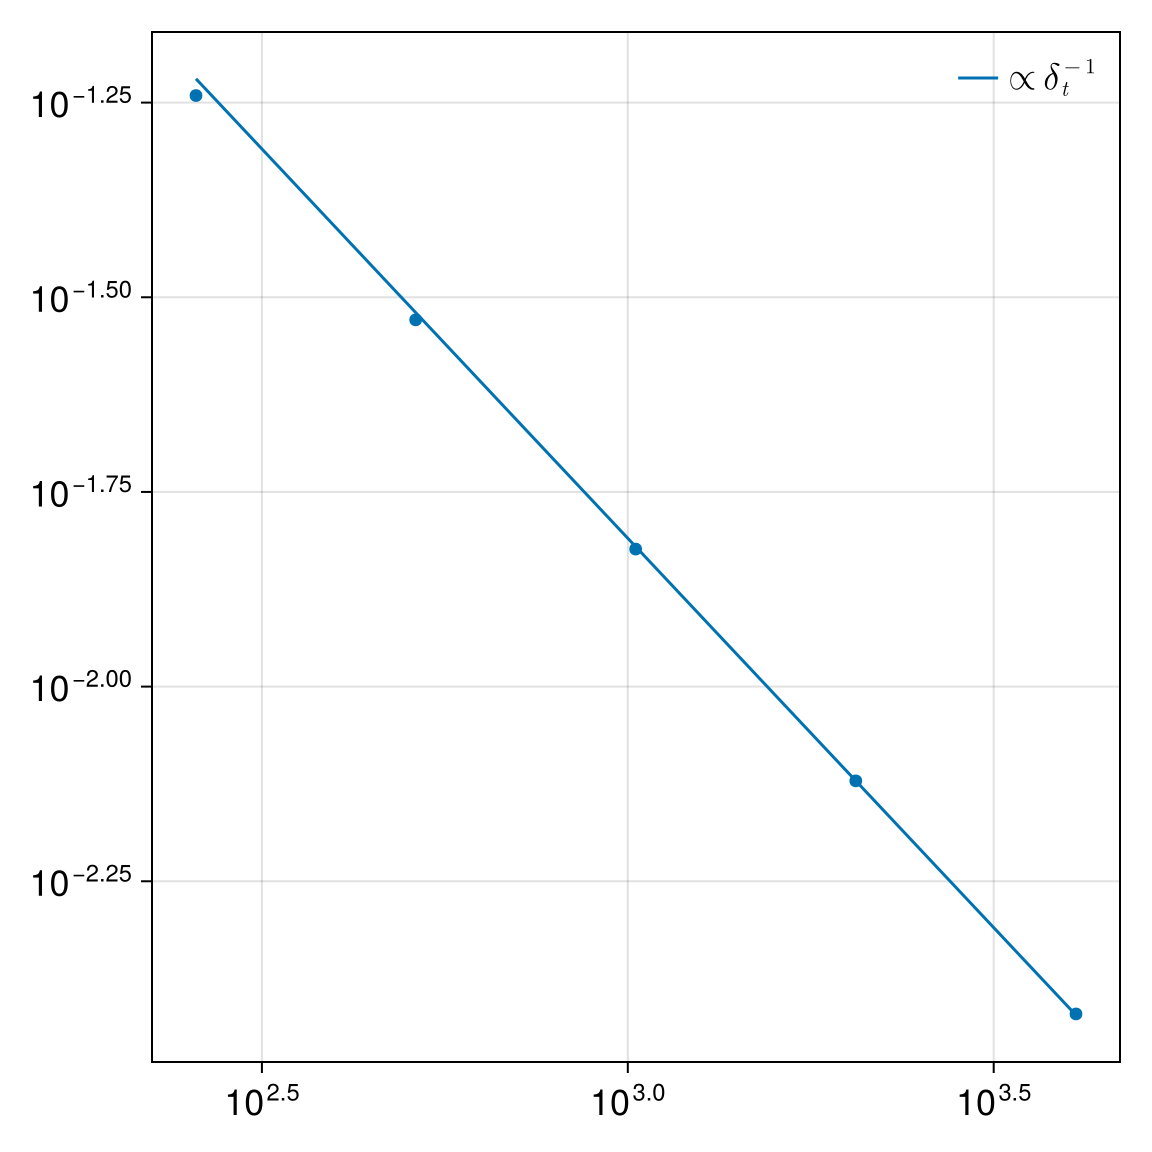

In [20]:
function plot_convergeance(figure_axis, observations)
    tab_N =  N_from_observation.(observations)
    errors = evaluate_error(observations)
    scatter!(figure_axis, tab_N[1:end-1], errors[1:end-1])
    rate = 1
    lines!(figure_axis, tab_N[1:end-1], errors[4] .* tab_N[4] .^ rate ./ tab_N[1:end-1] .^ rate,
        label=L"\propto \delta_t^{%$(-rate)}")
   axislegend(position=:rt, framevisible=false)
end
function plot_convergeance(observations)
    f = setup_figure()
    fig_axis = Axis(f[1,1],xscale=log10, yscale=log10,)
    plot_convergeance(fig_axis, observations)
    return f
end
plot_convergeance(result_time_VS_delta_dt_hss)

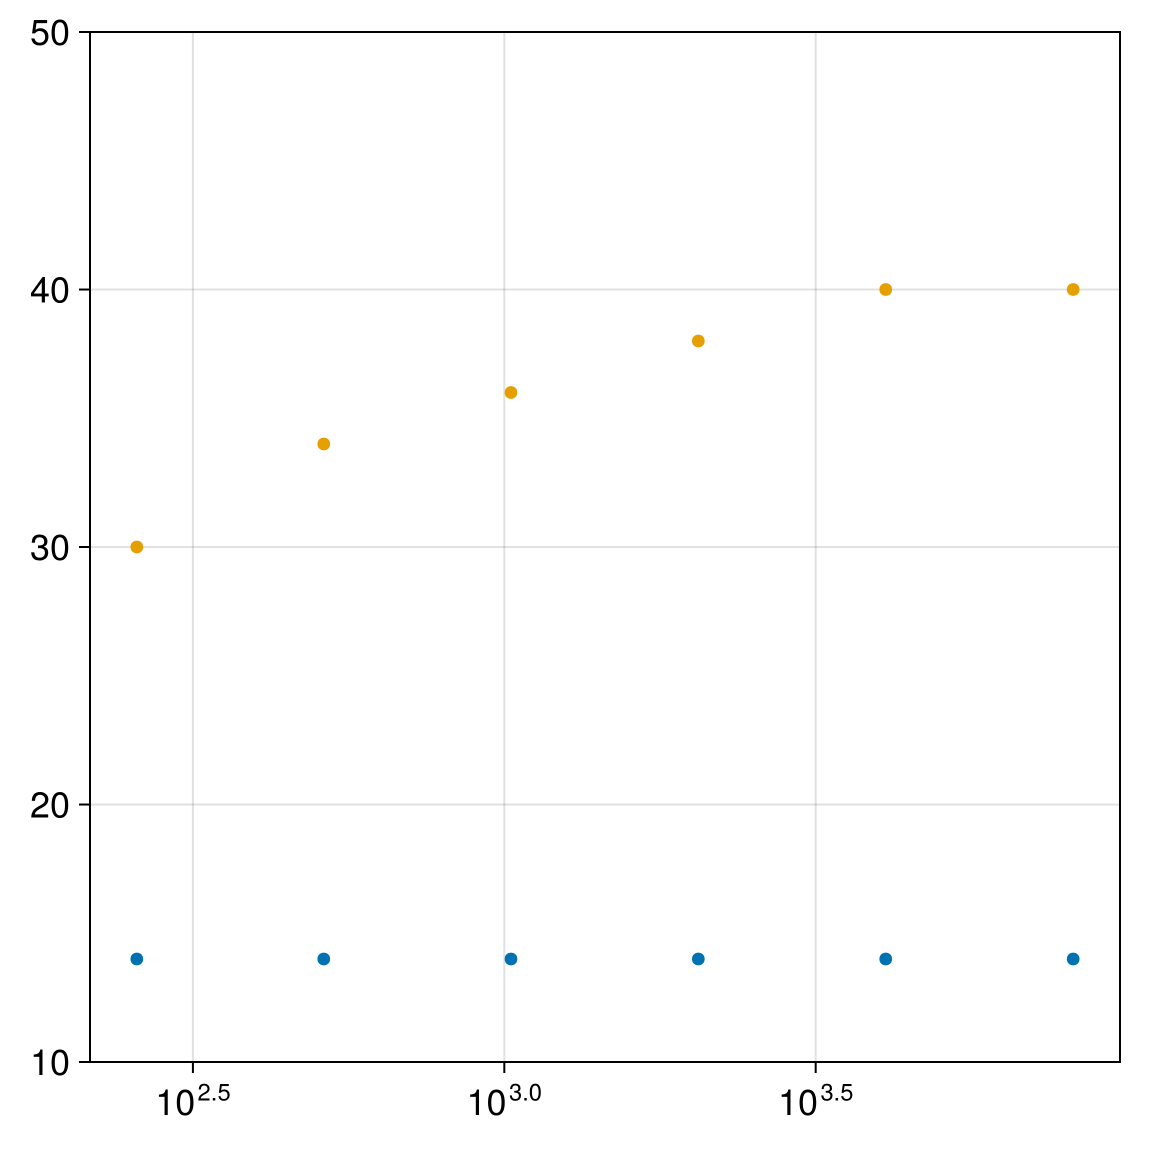

In [21]:
function plot_hss_rank(figure_axis, observations)
    ylims!(figure_axis, 10, 50)
    scatter!(figure_axis,
        N_from_observation.(observations),
        [r[:hssrank_GR] for r in observations],
        label=L"G^R")
    scatter!(figure_axis,
        N_from_observation.(observations),
        [r[:hssrank_GK] for r in observations],
        label=L"G^K")
end
function plot_hss_rank(observations)
    f = setup_figure()
    fig_axis = Axis(f[1, 1], xscale=log10,)
    plot_hss_rank(fig_axis, observations)
    return f
end
plot_hss_rank(result_time_VS_delta_dt_hss)

In [22]:
function get_T()
    benchmark_range_tf(local_default_compression())[1]
end
function rank_VS_tolerance_parameter()
    T = get_T()
    δϕ = phase_difference(T)
    δt = base_VS_tf_δt() ./ 2^3
    return JunctionParameters(δt=δt, T=T, ϕl=t -> -δϕ(t) / 2, ϕr=t -> δϕ(t) / 2, Δ=1, Γl=5, Γr=5, β=1E6)
end
function get_tols()
    return [10. ^(-k) for k in 1:8]
end
function observe_time_VS_tol()
    T  = get_T()
    return map(get_tols()) do tol
        param = rank_VS_tolerance_parameter()
        @show N(param) 
        cpr = local_default_compression()
        @time result = single_run(param,  HssCompression( atol = tol, rtol = tol,leafsize = cpr.leafsize, kest = cpr.kest))
        if cpr isa HssCompression
            return (hssrank_GR=hssrank(matrix(result[:G_R])), hssrank_GK=hssrank(matrix(result[:G_K])),
                param=param, I=result[:I])
        else
            return (I=result[:I], param=param)
        end
    end
end
observe_tol = observe_time_VS_tol();

N(param) = 1025
Computing Green functions
  0.887141 seconds (349.92 k allocations: 1.436 GiB, 30.99% gc time, 0.80% compilation time)
Computing current
  0.279944 seconds (186.28 k allocations: 582.540 MiB, 39.75% gc time)
  1.167678 seconds (536.33 k allocations: 2.005 GiB, 33.07% gc time, 0.61% compilation time)
N(param) = 1025
Computing Green functions
  0.801096 seconds (353.08 k allocations: 1.548 GiB, 26.37% gc time)
Computing current
  0.260598 seconds (191.79 k allocations: 683.015 MiB, 41.36% gc time)
  1.062150 seconds (544.99 k allocations: 2.215 GiB, 30.04% gc time)
N(param) = 1025
Computing Green functions
  1.057669 seconds (356.36 k allocations: 1.656 GiB, 34.19% gc time)
Computing current
  0.501404 seconds (193.74 k allocations: 780.126 MiB, 60.37% gc time)
  1.559412 seconds (550.22 k allocations: 2.417 GiB, 42.60% gc time)
N(param) = 1025
Computing Green functions
  0.987819 seconds (357.65 k allocations: 1.753 GiB, 33.39% gc time)
Computing current
  0.486201 secon

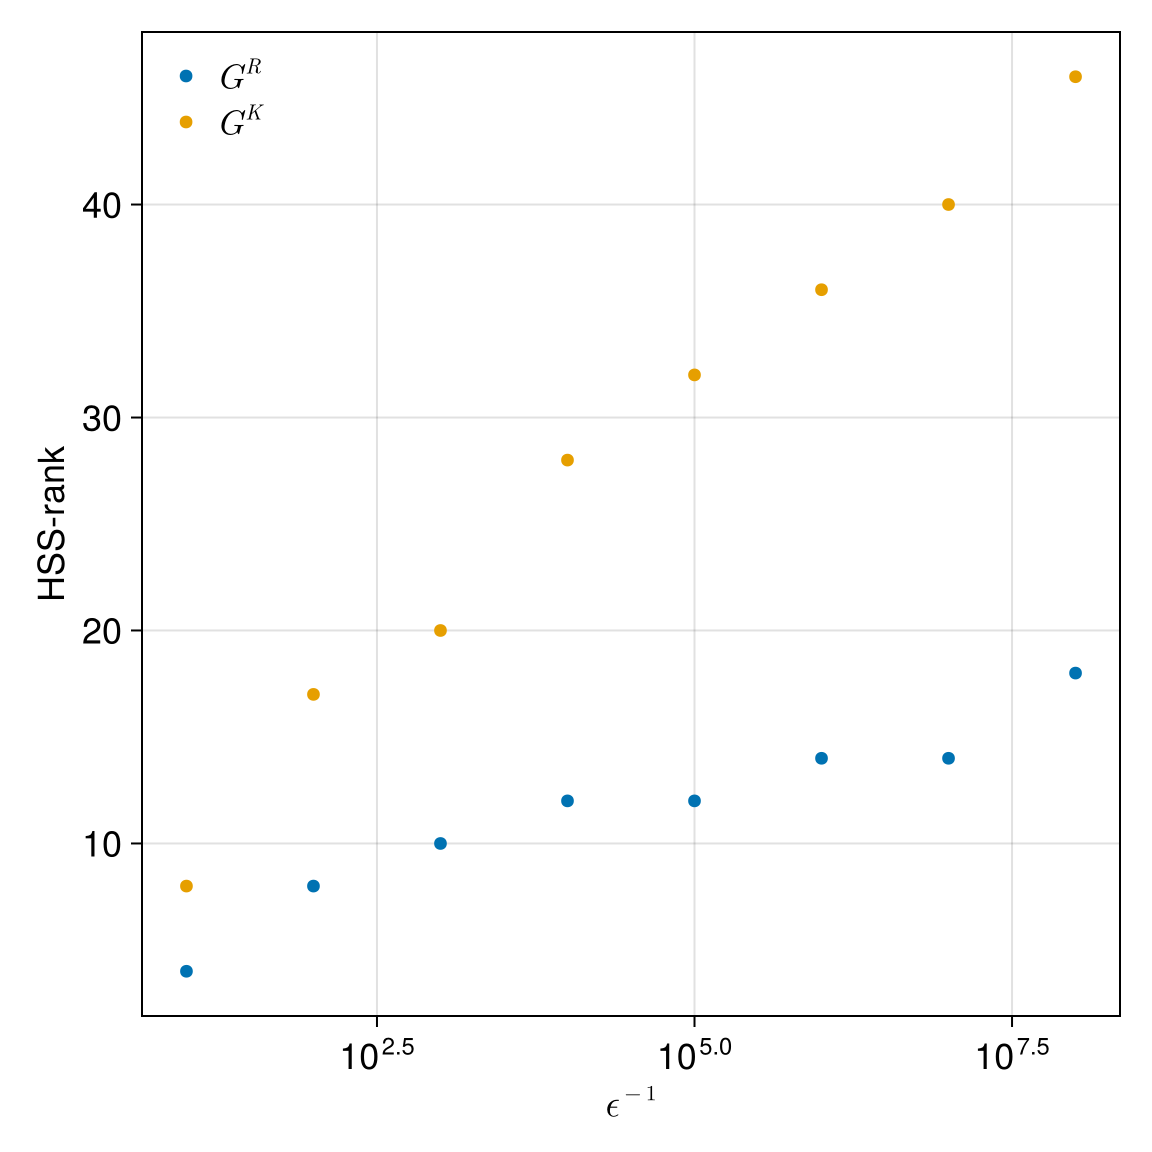

In [23]:
function plot_benchmarks_rank(benchmarl_tol,f_ax)
    tab_tol = get_tols()
    f = scatter!(f_ax,1 ./ tab_tol,[x[:hssrank_GR] for x in benchmarl_tol],label = L"G^R") 
    scatter!(f_ax, 1 ./ tab_tol ,[x[:hssrank_GK] for x in benchmarl_tol],label = L"G^K") 
    axislegend(position = :lt,framevisible = false)
    
    #save("SQDS_benchmark_ranks.pdf",f)
    return f
end
function plot_benchmarks_rank(benchmarl_tol)
    f = setup_figure()
    f_ax = Axis(f[1,1], xscale = log10,
    xlabel=L"\epsilon^{-1}",
    ylabel= "HSS-rank")
    plot_benchmarks_rank(benchmarl_tol, f_ax)
    return f
end

plot_benchmarks_rank(observe_tol)

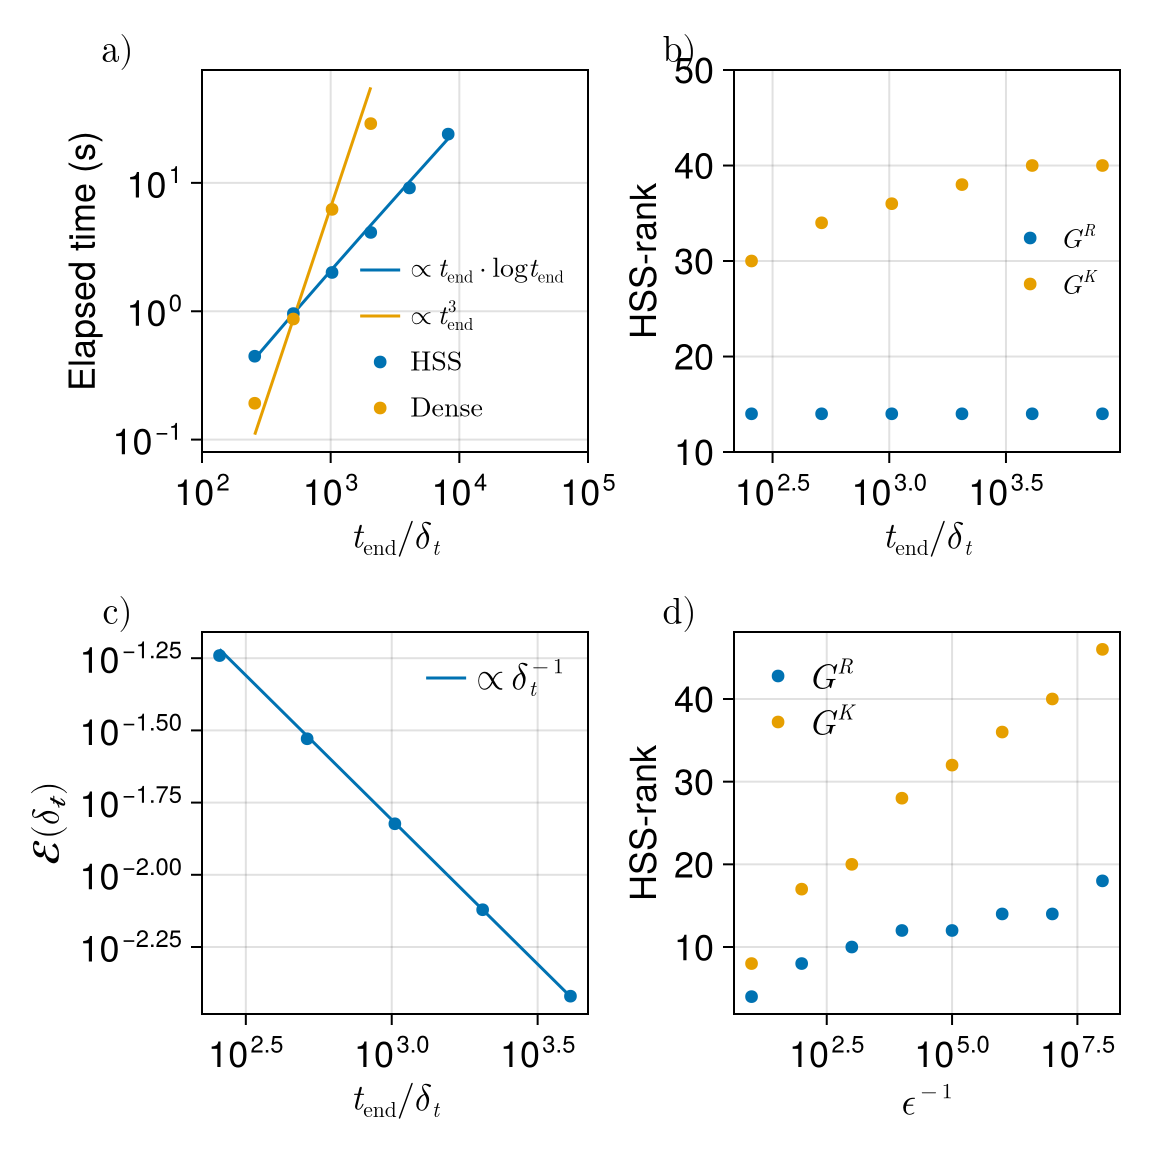

In [27]:
function plot_benchmark_N(observation_hss, observation_full, measure_hss, measure_full, observe_tol)
    function mediantime_s(measure)
        return median(measure.times) * 1E-9
    end

    prl_width = 3.38583
    size = 170 .* (prl_width, 1 * prl_width)
    f = Figure(size=size, fontsize=18)
    f_ax = Axis(f[1, 1], xscale=log10, yscale=log10,
        xlabel=L"t_\text{end}/\delta_t",
        ylabel="Elapsed time (s)")
    xlims!(1E2, 10^(5))
    asymptote_hss(x) = x * log(x)
    tendency_hss = asymptote_hss.(N_from_observation.(observation_hss)) ./ asymptote_hss(N_from_observation(observation_hss[2])) .* mediantime_s(measure_hss[2])
    lines!(f_ax, N_from_observation.(observation_hss),
        tendency_hss,
        label=L"\propto t_\text{end} \cdot \log t_\text{end}")
    asymptote_full(x) = x^3
    tendency_full = asymptote_full.(N_from_observation.(observation_full)) ./ asymptote_full(N_from_observation(observation_full[2])) .* mediantime_s(measure_full[2])
    lines!(f_ax, N_from_observation.(observation_full), tendency_full,
        label=L"\propto t_\text{end}^3")
    scatter!(f_ax,
        N_from_observation.(observation_hss),
        mediantime_s.(measure_hss),
        label=L"\text{HSS}")
    scatter!(f_ax,
        N_from_observation.(observation_full),
        mediantime_s.(measure_full),
        label=L"\text{Dense}")
    axislegend(position=:rb, framevisible=false, labelsize=14)
    Label(f[1,1,TopLeft()], L"\text{a)}")
    plot_hss_rank(
        Axis(f[1, 2], xscale=log10,
            xlabel=L"t_\text{end}/\delta_t",
            ylabel="HSS-rank"), observation_hss)
    axislegend(position=:rc, framevisible=false, labelsize=14)
    Label(f[1,2,TopLeft()], L"\text{b)}")
    tab_N_hss = N_from_observation.(observation_hss)
    plot_convergeance(
        Axis(f[2, 1],
            xscale=log10, yscale=log10,
            xlabel=L"t_\text{end}/\delta_t",
            #ylabel=L"\left(\int|\left\langle I_{\delta_t}(t)\right\rangle-\left\langle I_\text{ref}(t)\right\rangle|^2\text{d}t\right)/\left(\int|\left\langle I_\text{ref}(t)\right\rangle|^2\text{d}t\right)"
            #ylabel=L"\frac{||\left\langle I_{\delta_t}(t)\right\rangle-\left\langle I_\text{ref}(t)\right\rangle||_2}{||\left\langle I_\text{ref}(t)\right\rangle||_2}"
            ylabel=L"\mathcal{E(\delta_t)}"
        ),
        observation_hss)
    Label(f[2,1,TopLeft()], L"\text{c)}")
    f_ax = Axis(f[2, 2], xscale=log10,
        xlabel=L"\epsilon^{-1}",
        ylabel="HSS-rank")
    plot_benchmarks_rank(observe_tol, f_ax)
    Label(f[2,2,TopLeft()], L"\text{d)}")
    f
end
f = plot_benchmark_N(result_time_VS_delta_dt_hss, result_time_VS_delta_dt_full, measure_time_VS_delta_dt_hss, measure_time_VS_delta_dt_full, observe_tol)
save("../plots/SQDS_benchmark_varying_N.pdf", f, pt_per_unit=1)
f